In [1]:
#code to connect the google drive to the google colab if running on google colab
#from google.colab import drive
#drive.mount('myGDrive')

Mounted at myGDrive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
torch.manual_seed(0)

In [3]:
"""
Here a window size of 10 selected meaning that each log message is only dependent on 9 previous log messages in the sequence.
Then a dataset composed of N sequences of size L is created to train the model in a self-supervised manner.
"""
L = 10 # Window size (L-1 entries as the input stream and 1 entry as the corresponding output log)
logs = pd.read_csv('OpenStack/ParsingResults/openstack_normal2.log_structured.csv')
templates = pd.read_csv('OpenStack/ParsingResults/openstack_normal2.log_templates.csv')
events = list(logs['EventTemplate'])
t_lookup = list(templates['EventTemplate'])
log_set_size = len(t_lookup)
raw_data = []
data_set = []
for e in events:
    raw_data.append(t_lookup.index(e))
for i in range(len(raw_data) - L + 1):
    row = raw_data[i:i+L]
    data_set.append(row)
train_data = torch.tensor(data_set)

In [4]:
# A data-loader structure is used to store the training dataset
torch.manual_seed(0)
batch_size = 2000
tr_dataset = torch.utils.data.TensorDataset(train_data)
tr_loader = torch.utils.data.DataLoader(tr_dataset, batch_size=batch_size, shuffle=True)

In [5]:
# This model is stacking a convolutional neural network and a two-layer LSTM
class logConvRNN(torch.nn.Module):
    def __init__(self, log_set_size = 10, embedding_dim = 75, hidden_size = 8, 
                 num_layers = 2, num_filters = 1, filter_size = 3, padding = 1, dropout = 0.1):
        super().__init__()
        self.embedder = torch.nn.Embedding(log_set_size, embedding_dim)
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 1, out_channels = num_filters, kernel_size = filter_size, padding = padding),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_filters)
        )
        self.rnn = torch.nn.LSTM(input_size = embedding_dim, hidden_size = hidden_size, 
                                 num_layers = num_layers, dropout = dropout, batch_first = True)
        self.linear = torch.nn.Linear(hidden_size, log_set_size)
    def forward(self, X, h_0 = None):
        """
        This method feeds forward our model with input X.
        Arguments:
        X: A tensor of shape (N,L-1)
        h_0: The initial hidden layer
        
        Outputs:
        out: A tensor of shape (N,log_set_size) containing the logits for producing the probabilities of the Lth elemenet of each sequence
        h_n: The last hidden state
        """
        EX = self.embedder(X)
        CX = self.cnn(torch.unsqueeze(EX,1))
        Z, h_n = self.rnn(torch.squeeze(CX), h_0)
        z = Z[:,-1,:]
        out = self.linear(z)
        return out, h_n

In [6]:
torch.manual_seed(0)
num_epoch = 100
lr = 1e-3
hidden_size = 256
num_layers = 2
num_filters = 1
filter_size = 3
padding = 1
embedding_dim = 75
dropout = 0.5
device = 'cuda:0'
lcrnn = logConvRNN(log_set_size = log_set_size, embedding_dim = embedding_dim, 
              hidden_size = hidden_size, num_layers = num_layers, num_filters = num_filters, 
              filter_size = filter_size, padding = padding, dropout = dropout)
lcrnn.to(device)
loss = torch.nn.CrossEntropyLoss()
loss.to(device)
optimizer = torch.optim.Adam(lcrnn.parameters(), lr = lr)
train_loss = []
for epoch in range(num_epoch):
    for i, X in enumerate(tr_loader):
        X = X[0]
        y = X[:,-1]
        X = X[:,0:-1]
        X = X.to(device)
        y = y.to(device)
        out, h_n = lcrnn(X)
        l = loss(out, y)
        lcrnn.zero_grad()
        l.backward()
        optimizer.step()
    train_loss.append(l.item())
    if(epoch+1) % 10 == 0:
        print("Epoch %03d: training loss: %.4f" %(epoch+1, l.item()))

Epoch 010: training loss: 1.5396
Epoch 020: training loss: 1.2760
Epoch 030: training loss: 1.0041
Epoch 040: training loss: 0.8680
Epoch 050: training loss: 0.7097
Epoch 060: training loss: 0.6933
Epoch 070: training loss: 0.4753
Epoch 080: training loss: 0.4071
Epoch 090: training loss: 0.4649
Epoch 100: training loss: 0.4177


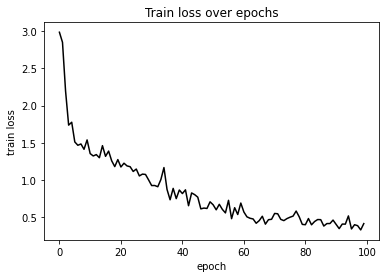

In [7]:
plt.figure()
plt.plot(train_loss, color = 'k')
plt.title("Train loss over epochs")
plt.xlabel('epoch')
plt.ylabel('train loss');

In [8]:
"""Here we randomly select 5000 samples from the training sequences and 
inject anomalies in 100 of them by changing their last elements.
In this way we produce a test set for measuring the performance of our model in detecting anomalies.
"""
torch.manual_seed(0)
lcrnn.eval()
total_anomalies = 100
sample_rows = torch.randint(0, len(data_set), (5000,))
test_data = train_data[sample_rows]
affected_rows = torch.randint(0, len(test_data), (total_anomalies,))
test_data[affected_rows,-1] = (test_data[affected_rows,-1] + 5) % log_set_size
X_test = test_data[:,0:-1]
y_test = test_data[:,-1]
X_test = X_test.to(device)
y_test = y_test.to(device)
out, h_n = lcrnn(X_test)
out = torch.nn.Softmax(1)(out)
y_test_pred = torch.max(out,1)[1]

In [9]:
"""Here we define some functions for measuring the performance of our model.
inputs:
y_pred: a one-dimentional tensor containing the predicted log indices.
y_true: a one-dimentional tensor containing the labels produced from the test set.
"""
def FalsePositiveRate(y_pred, y_true):
  FP = TN = 0
  for i in np.arange(len(y_pred)):
    if (y_pred[i] != y_true[i]) and not(i in affected_rows):
      FP += 1
    if (y_pred[i] == y_true[i]) and not(i in affected_rows):
      TN += 1
  return FP / (FP + TN)

def FalseNegativeRate(y_pred, y_true):
  FN = TP = 0
  for i in np.arange(len(y_pred)):
    if (y_pred[i] == y_true[i]) and (i in affected_rows):
      FN += 1
    if (y_pred[i] != y_true[i]) and (i in affected_rows):
      TP += 1
  return FN / (FN + TP)
def Precision(y_pred, y_true):
  TP = FP = 0
  for i in np.arange(len(y_pred)):
    if (y_pred[i] != y_true[i]) and (i in affected_rows):
      TP += 1
    if (y_pred[i] != y_true[i]) and not(i in affected_rows):
      FP += 1
  return TP / (TP + FP)

def Recall(y_pred, y_true):
  TP = FN = 0
  for i in np.arange(len(y_pred)):
    if (y_pred[i] != y_true[i]) and (i in affected_rows):
      TP += 1
    if (y_pred[i] == y_true[i]) and (i in affected_rows):
      FN += 1
  return TP / (TP + FN)
def Accuracy(y_pred, y_true):
  correct = 0
  for i in np.arange(len(y_pred)):
    if ((y_pred[i] != y_true[i]) and (i in affected_rows)) or ((y_pred[i] == y_true[i]) and not(i in affected_rows)):
      correct += 1
  return correct / len(y_pred)

In [10]:
print("The False Positive Rate of anomaly detection on the random sample: %.2f%%" % (FalsePositiveRate(y_test_pred, y_test) * 100))
print("The False Negative Rate of anomaly detection on the random sample: %.2f%%" % (FalseNegativeRate(y_test_pred, y_test) * 100))
print("The precision of anomaly detection on the random sample: %.2f%%" % (Precision(y_test_pred, y_test) * 100))
print("The recall measure of anomaly detection on the random sample: %.2f%%" % (Recall(y_test_pred, y_test) * 100))
print("The accuracy of anomaly detection on the random sample: %.2f%%" % (Accuracy(y_test_pred, y_test) * 100))

The False Positive Rate of anomaly detection on the random sample: 7.65%
The False Negative Rate of anomaly detection on the random sample: 0.00%
The precision of anomaly detection on the random sample: 20.55%
The recall measure of anomaly detection on the random sample: 100.00%
The accuracy of anomaly detection on the random sample: 92.50%
